In [1]:
from matplotlib.patches import Ellipse
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
import statsmodels.api as sm

%matplotlib inline
np.random.seed(42)

/anaconda3/envs/pymc/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Generating data
n = 100
x = np.linspace(0, 10, n)
beta = np.array([1, 0.1])
e = np.random.normal(size=n)

X = sm.add_constant(x)
y = np.dot(X, beta) + e

In [3]:
mod = sm.OLS(y, X)
res = mod.fit()
print("stasmodels\n")
print(res.params, '\n')
print(res.conf_int(0.05))

stasmodels

[ 0.82718715  0.11379327] 

[[ 0.46796326  1.18641103]
 [ 0.05173039  0.17585614]]


In [4]:
def lr_error(beta_guess, X, y):
    return np.dot(X, beta_guess) - y

sol_lr = optimize.least_squares(lr_error, [0, 0], args=(X, y,))
cost_lr = 2 * sol_lr.cost # sol_ls.cost is half sum of squares!
H_lr = np.dot(sol_lr.jac.T, sol_lr.jac)
cov0_lr = np.linalg.inv(H_lr)
df_lr = len(y.flatten()) - len(sol_lr.x)  # degrees of freedom
cov_lr = cov0_lr*cost_lr/df_lr
standard_error_lr = np.sqrt(np.diag(cov_lr))  # same as statsmodels

t_stats = (sol_lr.x - 0)/standard_error_lr  # also as statsmodels

ci_deltas_lr = stats.t.isf(0.025, df=df_lr) * standard_error_lr

print('optimize.least_squares\n')
print(sol_lr.x, '\n')
print(np.array([sol_lr.x -  ci_deltas_lr, sol_lr.x + ci_deltas_lr]).T)

optimize.least_squares

[ 0.82718715  0.11379327] 

[[ 0.46796326  1.18641103]
 [ 0.05173039  0.17585614]]


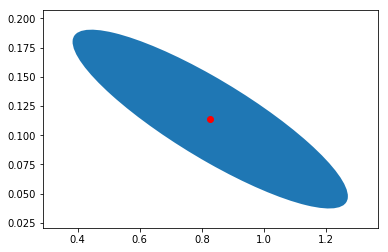

In [5]:
# Drawing the covariance matrix
# http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

# Eigen value decomposition
eigvals, eigvecs = np.linalg.eigh(cov_lr)

# The counter-clock angle to rotate our ellipse by 
vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
theta = np.arctan2(vy, vx)

# Scale for confidence interval
scale = np.sqrt(stats.chi2.ppf(0.95, 2))

# The elements of the elipse
centre = sol_lr.x
width, height = 2 * scale * np.sqrt(eigvals)

# Creating an elipse with matplotlib's Ellipse patch
e = Ellipse(xy=centre, width=width, height=height,
               angle=np.degrees(theta))
# Drawing the figure
fig, ax = plt.subplots()
ax.add_artist(e)
ax.plot(centre[0], centre[1], 'ro')
ax.set_xlim((centre[0] - ci_deltas_lr[0]*1.5), centre[0] + ci_deltas_lr[0]*1.5)
ax.set_ylim(centre[1] - ci_deltas_lr[1]*1.5, centre[1] +ci_deltas_lr[1]*1.5);